# Exercise 3: Linear Prediction

In [1]:
import librosa
import numpy as np
from scipy.linalg import solve_toeplitz
from scipy.signal import get_window, freqz, lfilter
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 4)

In [2]:
# "Import" functions from exercise 1

import requests

gist = requests.get(
    "https://gist.githubusercontent.com/iibrahimli/3c50f73020c78aeee1de68ae5a0ba5e7/raw/import_funcs.py"
).text
print("Downloaded import_funcs.py")
exec(gist)

import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "plot_signal",
    ],
)

Downloaded import_funcs.py
Found exercise1.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise1/exercise1.ipynb
Executed function plot_signal
Successfully imported functions: ['plot_signal']


## 1. Load `speech1.wav`

In [3]:
s, fs = librosa.core.load("../Exercise2/Audio/speech1.wav")
s.shape, fs

((62658,), 22050)

## 2. Select voiced and unvoiced segments

In [4]:
segment_len = int(32 / 1000 * fs) # 32 ms
voiced_start = int(400 / 1000 * fs) # 400 ms
unvoiced_start = int(550 / 1000 * fs) # 550 ms

voiced_s = s[voiced_start:voiced_start+segment_len]
unvoiced_s = s[unvoiced_start:unvoiced_start+segment_len]

# Apply the Hann window to the voiced and unvoiced segments
window = get_window("hann", segment_len)
voiced_s = voiced_s * window
unvoiced_s = unvoiced_s * window

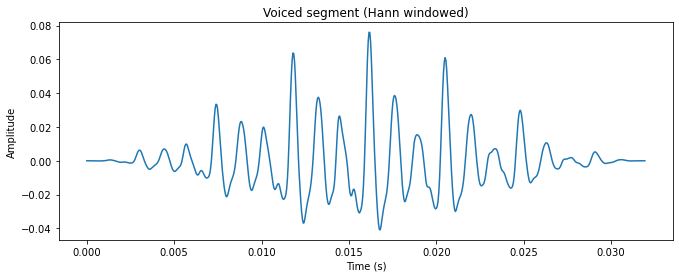

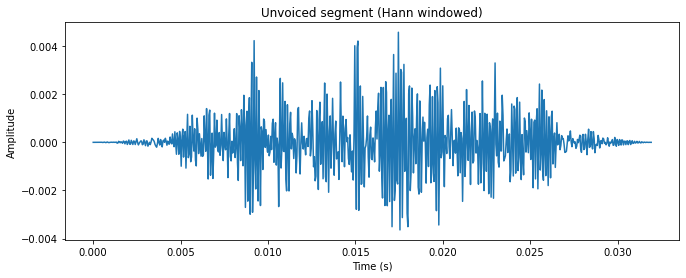

In [5]:
plot_signal(voiced_s, fs, "Voiced segment (Hann windowed)")
plot_signal(unvoiced_s, fs, "Unvoiced segment (Hann windowed)")

## 3. Compute LP coefficients

In [6]:
M = 12 # LPC order

In [7]:
def estimate_filter(segment, M=12):
    """Solve Toeplitz system, returns vector a of LPC coefficients"""
    # Estimate autocorrelation
    r = np.correlate(segment, segment, mode="full")
    r = r[len(r) // 2:]

    # Take the first M+1 elements of the autocorrelation vector
    r = r[:M+1]

    # Solve the Toeplitz system
    a = solve_toeplitz(r[:-1], r[1:])
    return a

In [8]:
a_voiced = estimate_filter(voiced_s, M)
a_voiced

array([  5.05098356, -12.59926553,  21.8016928 , -30.83992439,
        37.81599979, -39.81203095,  35.50185791, -27.1173312 ,
        17.84801738,  -9.5636052 ,   3.57398394,  -0.66963117])

In [9]:
a_unvoiced = estimate_filter(unvoiced_s, M)
a_unvoiced

array([  2.08581525,  -4.20923977,   6.52346923,  -8.8414268 ,
        10.20188208, -10.6117754 ,   9.45941963,  -7.63653992,
         5.19440093,  -3.07560183,   1.37227139,  -0.53358707])

## 4. Frequency response

### a) Plot the frequency response of the LP filter

In [10]:
def plot_freq_response(s, fs, M, title):
    """Plots the frequency response of the filter"""

    a = estimate_filter(s, M)
    w, h = freqz(1, np.concatenate(([1], a)), len(s), whole=True, fs=fs)

    fig, ax = plt.subplots(1, 2)
    ax[0].plot(w, 20 * np.log10(np.abs(h)))
    ax[0].set_title("Magnitude response")
    ax[0].set_xlabel("Frequency (Hz)")
    ax[0].set_ylabel("Magnitude (dB)")
    ax[0].grid()

    ax[1].plot(w, np.angle(h))
    ax[1].set_title("Phase response")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("Phase (rad)")
    ax[1].grid()

    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

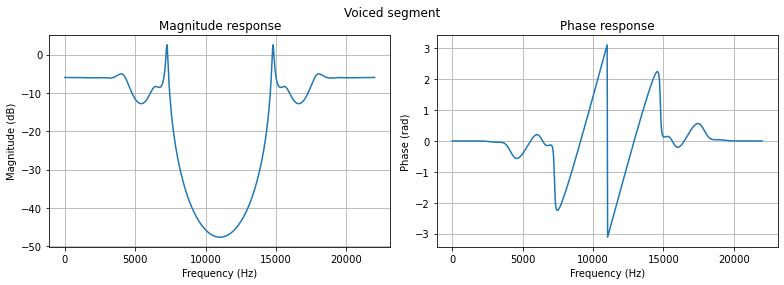

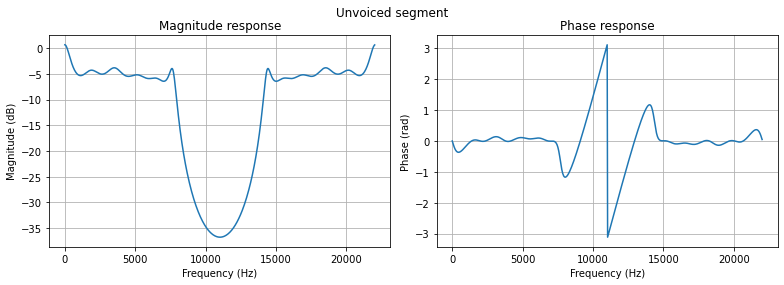

In [11]:
plot_freq_response(voiced_s, fs, M, "Voiced segment")
plot_freq_response(unvoiced_s, fs, M, "Unvoiced segment")

### b) Using `np.concatenate(([1], a))`

We used `np.concatenate(([1], a))` instead of just `a` because the filter coefficients are the coefficients of the denominator of the transfer function, which is $1 + a_1 z^{-1} + a_2 z^{-2} + \dots + a_p z^{-p}$. The additional $1$ is first term in the denominator.

## 5. DFT of windowed segments

In [12]:
def plot_dft(s, fs, title):
    """Plots the DFT of the signal"""
    S = np.fft.rfft(s)
    freqs = np.fft.rfftfreq(len(s), 1 / fs)

    a = estimate_filter(s, M)
    w, h = freqz(1, np.concatenate(([1], a)), len(s), fs=fs)

    fig, ax = plt.subplots(1, 1)
    ax.plot(freqs, 20 * np.log10(np.abs(S)), label="S(z)")
    ax.plot(w, 20 * np.log10(np.abs(h)), color="red", label="H(z)")
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude (dB)")
    ax.grid()
    ax.legend()

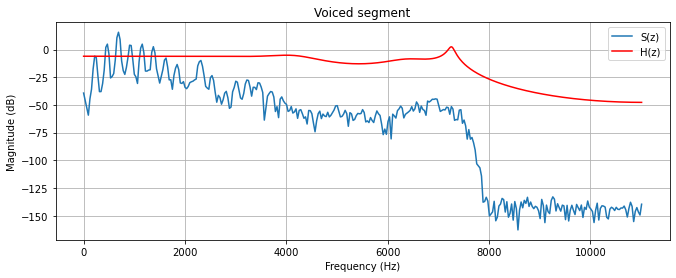

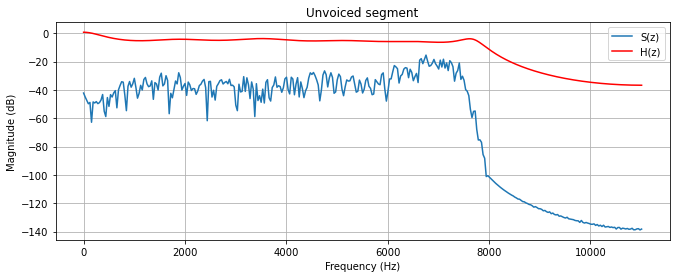

In [13]:
plot_dft(voiced_s, fs, "Voiced segment")
plot_dft(unvoiced_s, fs, "Unvoiced segment")

## 6. Residual signal

### a) Compute and plot the residual signal

In [14]:
def plot_residual(s, a, M, title):
    """Plots the signal and residual signal"""
    e = lfilter(np.concatenate(([1], a)), 1, s)

    fig, ax = plt.subplots(1, 1)
    ax.plot(e, color="red", label="Residual signal")
    ax.plot(s, label="Signal")
    ax.set_title(title)
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Amplitude")
    ax.grid()
    ax.legend()

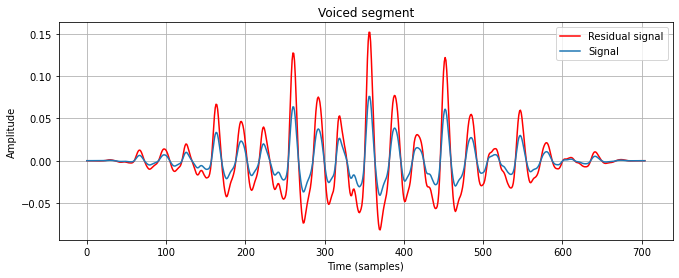

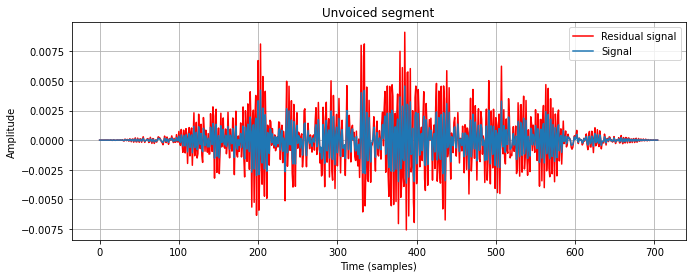

In [15]:
plot_residual(voiced_s, estimate_filter(voiced_s, M), M, "Voiced segment")
plot_residual(unvoiced_s, estimate_filter(unvoiced_s, M), M, "Unvoiced segment")

### b) Differences in `e` between the voiced and unvoiced segments

The residual signal of the voiced segments is periodic like the original signal, unlike `e` for the unvoiced signal. Both original and residual signals are noisy for the unvoiced segment.

### c) Why `lfilter(np.concatenate(([1], a)), 1, s)` yields the residual signal

TODO

## 7. Modifying H

### a) Why are the log amplitudes of H and S not on the same level?

TODO

### b) Modifying H to achieve a better match (experiment with the energy of the residual `e`)

In [16]:
# Compute the energy of the residual signal
def energy(s):
    return np.sum(s ** 2)

In [21]:
# TODO

## 8. Different order `M`

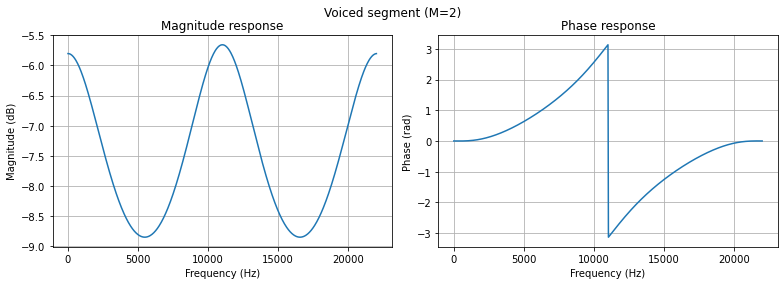

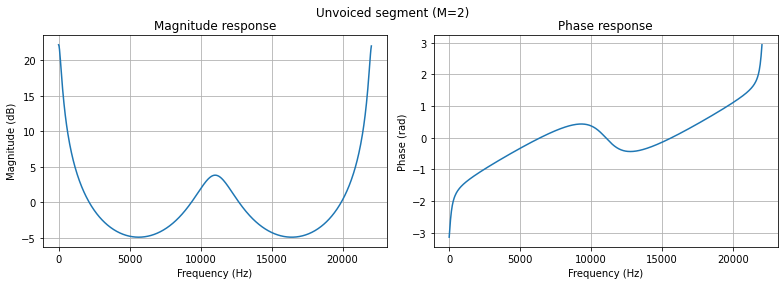

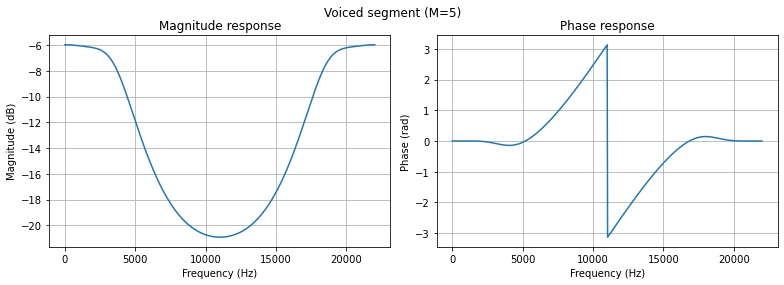

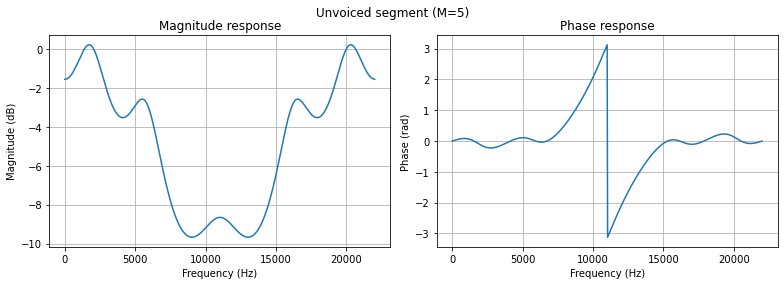

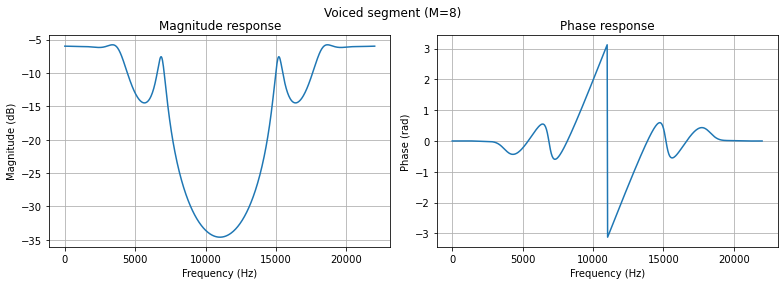

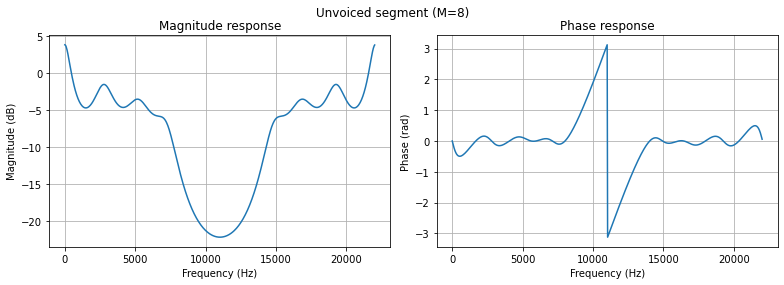

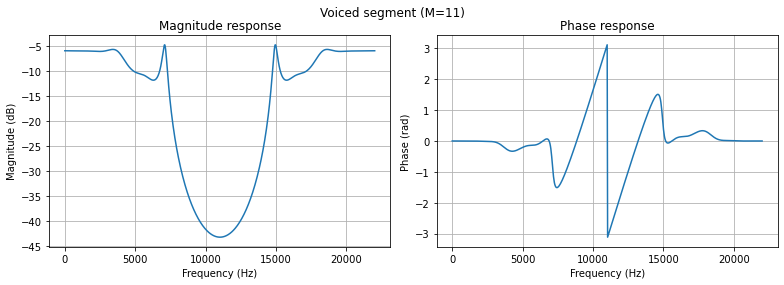

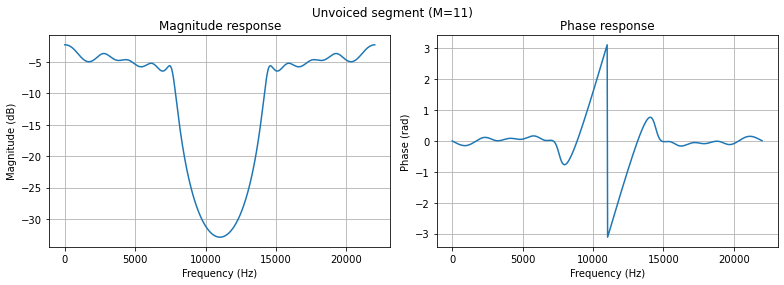

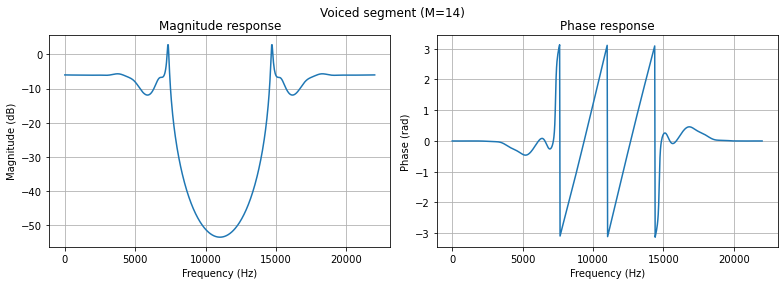

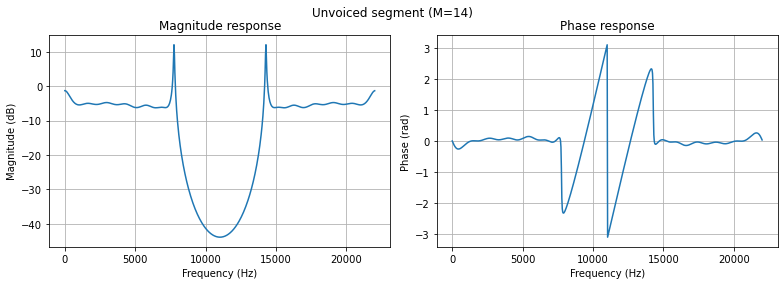

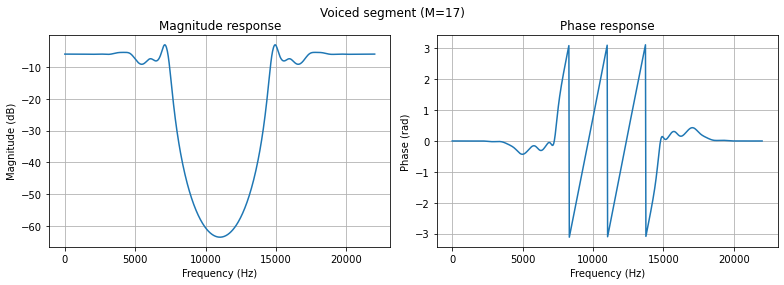

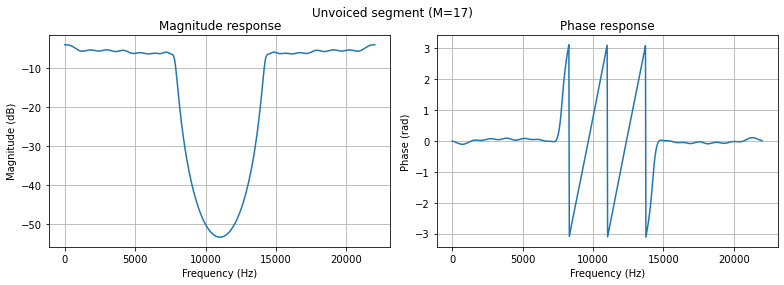

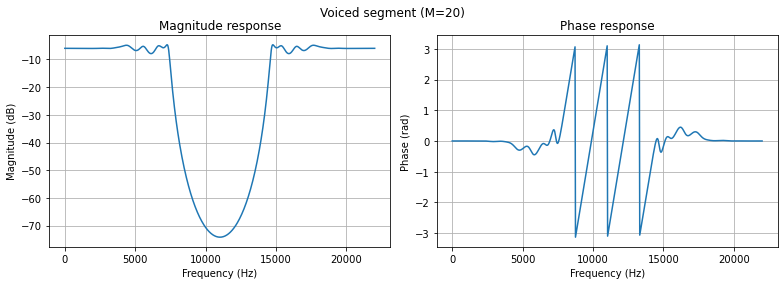

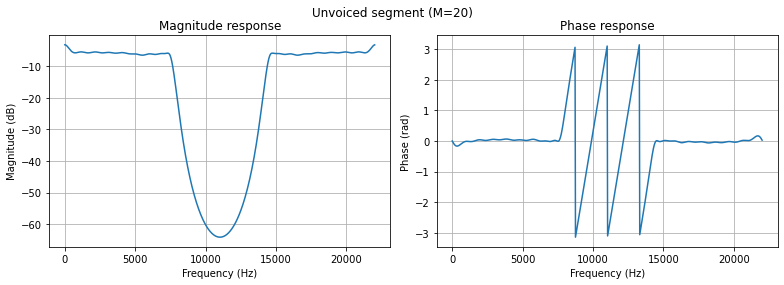

In [23]:
for M in range(2, 21, 3):
    a_voiced = estimate_filter(voiced_s, M)
    a_unvoiced = estimate_filter(unvoiced_s, M)
    
    plot_freq_response(voiced_s, fs, M, f"Voiced segment (M={M})")
    plot_freq_response(unvoiced_s, fs, M, f"Unvoiced segment (M={M})")    

TODO explanation how H(z) changes with M

## 9. Pre-emphasis

### a) Computing LP coefficients for pre-emphasized signal

In [24]:
# TODO

### b) Advantages of pre-emphasizing the speech signal

TODO